In [17]:
from pathlib import Path
import pandas as pd
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


In [18]:
# ----------------------------------------------
# Paso 1: Cargar y revisar datos de jugador externo (Lamine Yamal)
# ----------------------------------------------

import pandas as pd

# === Carga de datos ===
future_logs = pd.read_csv("data/processed/future_stars_cleaned_matchlogs.csv")
future_meta = pd.read_csv("data/processed/future_stars_cleaned_metadata.csv")

# === Selección dinámica de jugador ===
# Puedes cambiar aquí el nombre del jugador, o directamente usar un Player_ID
player_name = "Lamine Yamal"  # 👈 Cámbialo por otro nombre como 'Endrick', 'Mathys Tel'...
player_id = future_meta[future_meta['Player_name'] == player_name]['Player_ID'].values[0]

# === Filtrar y merge ===
future_df = future_logs[future_logs['Player_ID'] == player_id].copy()
future_df = future_df.merge(
    future_meta[['Player_ID', 'Birth_date', 'Position']],
    on='Player_ID', how='left'
)

# === Formato fechas y edad ===
future_df['Date'] = pd.to_datetime(future_df['Date'], errors='coerce')
future_df['Birth_date'] = pd.to_datetime(future_df['Birth_date'], errors='coerce')
future_df['Age'] = (future_df['Date'] - future_df['Birth_date']).dt.days / 365.25

# === Verificación
print(f"🧍 Jugador seleccionado: {player_name} ({player_id})")
print(future_df[['Player_name', 'Date', 'Age', 'Minutes', 'Goals', 'Assists']].head())





🧍 Jugador seleccionado: Lamine Yamal (82ec26c1)
    Player_name       Date        Age Minutes Goals Assists
0  Lamine Yamal 2023-04-29  15.794661       8     0       0
1  Lamine Yamal 2023-09-08  16.156057      47     1       0
2  Lamine Yamal 2023-09-12  16.167009      60     0       0
3  Lamine Yamal 2023-11-16  16.344969      72     1       0
4  Lamine Yamal 2023-11-19  16.353183      26     0       0


In [19]:
# ----------------------------------------------
# Paso 2: Calcular rating_per_90 como en el modelo original
# ----------------------------------------------

# 1. Convertimos columnas relevantes a numérico y rellenamos nulos
rating_cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
for col in rating_cols:
    future_df[col] = pd.to_numeric(future_df[col], errors='coerce').fillna(0)

# 2. Función de cálculo
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] >= 1 else 0  # evitamos divisiones muy pequeñas

# 3. Aplicamos la fórmula
future_df['rating_per_90'] = future_df.apply(calculate_rating, axis=1)

# 4. Filtramos por partidos relevantes (al menos 70 minutos jugados)
future_df = future_df[future_df['Minutes'] >= 70].copy()

# 5. Ejemplo
print("\n🎯 Ejemplo de rating_per_90 calculado por partido:")
print(future_df[['Date', 'Minutes', 'Goals', 'Assists', 'rating_per_90']].head())




🎯 Ejemplo de rating_per_90 calculado por partido:
        Date  Minutes  Goals  Assists  rating_per_90
3 2023-11-16       72      1        0       6.875000
6 2024-03-26       89      0        1       4.044944
7 2024-06-08       71      0        2      10.140845
8 2024-06-15       85      0        1       4.976471
9 2024-06-20       70      0        0       0.128571


In [20]:
# ----------------------------------------------
# Paso 3: Agregación por año natural y creación de perfil anual
# ----------------------------------------------

# 1. Año natural
future_df['Natural_year'] = future_df['Date'].dt.year

# 2. Año de debut con minutos > 0
debut_year = future_df[future_df['Minutes'] > 0]['Natural_year'].min()

# ⚠️ Validación
if pd.isna(debut_year):
    raise ValueError("❌ El jugador no tiene minutos registrados en ningún año.")

# 3. Año relativo desde debut
future_df['year_since_debut'] = future_df['Natural_year'] - debut_year + 1

# 4. Agregado anual
player_seasonal = future_df.groupby('year_since_debut').agg({
    'rating_per_90': 'mean',
    'Age': 'mean',
    'Minutes': 'sum'
}).reset_index()

# 5. Pivot
pivot_rating = player_seasonal.pivot(columns='year_since_debut', values='rating_per_90')
pivot_age = player_seasonal.pivot(columns='year_since_debut', values='Age')
pivot_minutes = player_seasonal.pivot(columns='year_since_debut', values='Minutes')

# 6. Renombrado
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# 7. Unión de features
player_model_df = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1)

# 8. Variables derivadas
if 'rating_year_2' in player_model_df.columns and 'rating_year_1' in player_model_df.columns:
    player_model_df['growth_2_1'] = player_model_df['rating_year_2'] - player_model_df['rating_year_1']
if 'rating_year_3' in player_model_df.columns and 'rating_year_2' in player_model_df.columns:
    player_model_df['growth_3_2'] = player_model_df['rating_year_3'] - player_model_df['rating_year_2']

player_model_df['avg_rating'] = player_model_df[[col for col in player_model_df.columns if 'rating_year_' in col]].mean(axis=1)
player_model_df['sum_minutes'] = player_model_df[[col for col in player_model_df.columns if 'minutes_year_' in col]].sum(axis=1)

if 'rating_year_3' in player_model_df.columns and 'rating_year_1' in player_model_df.columns:
    player_model_df['rating_trend'] = player_model_df['rating_year_3'] - player_model_df['rating_year_1']
if 'minutes_year_3' in player_model_df.columns and 'minutes_year_1' in player_model_df.columns:
    player_model_df['minutes_trend'] = player_model_df['minutes_year_3'] - player_model_df['minutes_year_1']

# 9. Verificación
print(f"\n🧠 Perfil anual de {player_name}:")
display(player_model_df.T)




🧠 Perfil anual de Lamine Yamal:


,0,1,2
rating_year_1,2.494785,NaN,NaN
rating_year_2,NaN,3.888485,NaN
rating_year_3,NaN,NaN,4.118471
age_year_1,16.265845,NaN,NaN
age_year_2,NaN,16.974364,NaN
age_year_3,NaN,NaN,17.663139
minutes_year_1,810.000000,NaN,NaN
minutes_year_2,NaN,3813.000000,NaN
minutes_year_3,NaN,NaN,2363.000000
growth_2_1,NaN,NaN,NaN



📊 Estadísticas anuales del jugador


,year_since_debut,Goals,Assists,Minutes,Matches,G+A
0,1,2,2,810,10,4
1,2,11,21,3813,44,32
2,3,9,8,2363,26,17


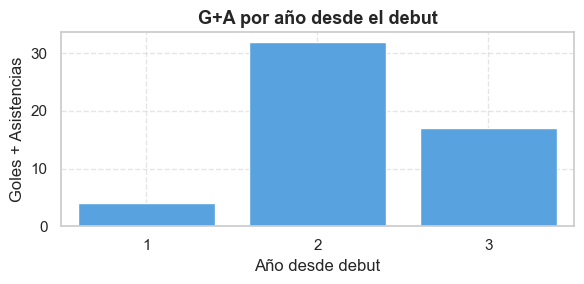

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Agregación de estadísticas por año desde el debut
player_stats = future_df.groupby('year_since_debut').agg({
    'Goals': 'sum',
    'Assists': 'sum',
    'Minutes': 'sum',
    'Date': 'count'  # partidos
}).rename(columns={'Date': 'Matches'}).reset_index()

player_stats['G+A'] = player_stats['Goals'] + player_stats['Assists']

# 2. Mostrar tabla
print("\n📊 Estadísticas anuales del jugador")
display(player_stats)

# 3. Gráfico de G+A por año
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(
    data=player_stats,
    x='year_since_debut',
    y='G+A',
    color="#42a5f5",
    ax=ax
)

ax.set_title("G+A por año desde el debut", fontsize=13, weight='bold')
ax.set_xlabel("Año desde debut")
ax.set_ylabel("Goles + Asistencias")
ax.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()

In [22]:
import joblib

# 1. Cargar modelo entrenado
model = joblib.load('model/futpeak_model_multi.joblib')

# 2. Cargar LabelEncoder
le = joblib.load('model/label_encoder.joblib')

# 3. Cargar curvas promedio por grupo
df_curves = joblib.load('model/curvas_promedio.joblib')

# 4. Cargar columnas del modelo (orden correcto)
model_features = joblib.load('model/model_features.joblib')



In [23]:
import joblib

# ----------------------------------------------
# Paso 4: Predicción de grupo con modelo entrenado
# ----------------------------------------------

# Cargamos objetos
model = joblib.load("model/futpeak_model_multi.joblib")
le = joblib.load("model/label_encoder.joblib")
model_columns = joblib.load("model/model_features.joblib")

# Aseguramos orden y columnas
X_input = player_model_df.reindex(columns=model_columns, fill_value=0)

# Predicción
pred_encoded = model.predict(X_input)[0]
pred_label = le.inverse_transform([pred_encoded])[0]

# Mostrar
print(f"\n🎯 Predicción del modelo para {player_name}:")
print(f"🧠 Grupo estimado: {pred_label}")




🎯 Predicción del modelo para Lamine Yamal:
🧠 Grupo estimado: joven estrella


In [26]:
# Obtener curva del grupo predicho y proyectada
group_curve = df_curves[df_curves['peak_group'] == pred_label].copy()

# Ajustar proyección
last_real_year = player_seasonal['year_since_debut'].max()
last_real_rating = player_seasonal.loc[player_seasonal['year_since_debut'] == last_real_year, 'rating_per_90'].values[0]
ref_value = group_curve.loc[group_curve['year_since_debut'] == last_real_year, 'rating_avg'].values[0]

shift = last_real_rating - ref_value
group_curve['projection'] = group_curve['rating_avg'] + shift

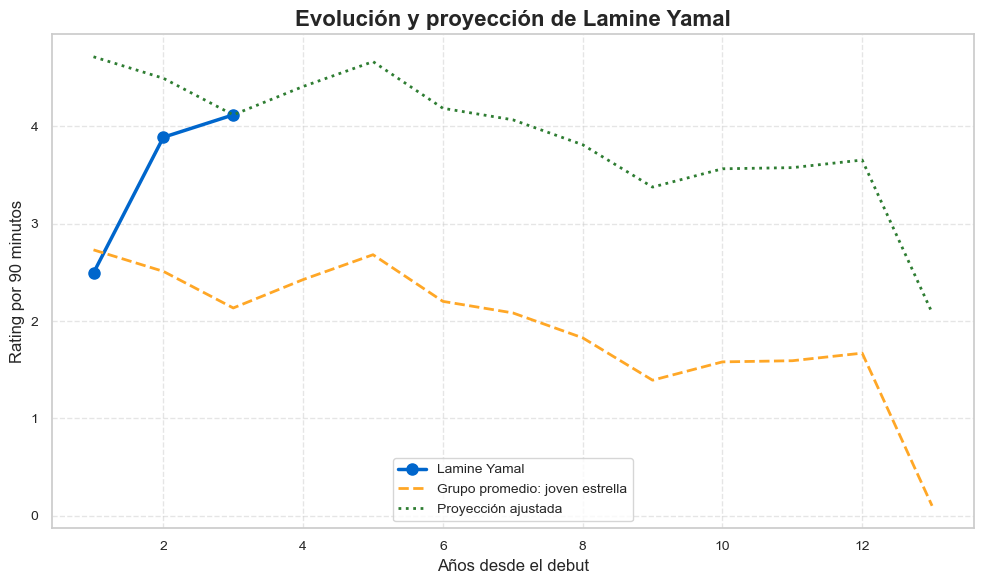

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set_theme(style="whitegrid")

# ✂️ Limitar a los primeros 13 años desde debut
player_filtered = player_seasonal[player_seasonal['year_since_debut'] <= 13]
group_filtered = group_curve[group_curve['year_since_debut'] <= 13]

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# 📈 Curva real del jugador
ax.plot(
    player_filtered['year_since_debut'],
    player_filtered['rating_per_90'],
    marker='o', markersize=8, linewidth=2.5,
    color="#0066cc", label=player_name
)

# 📉 Curva promedio del grupo
ax.plot(
    group_filtered['year_since_debut'],
    group_filtered['rating_avg'],
    linestyle='--', linewidth=2,
    color="#ffa726", label=f"Grupo promedio: {pred_label}"
)

# 🔮 Proyección ajustada
ax.plot(
    group_filtered['year_since_debut'],
    group_filtered['projection'],
    linestyle=':', linewidth=2,
    color="#2e7d32", label="Proyección ajustada"
)

# Títulos y ejes
ax.set_title(f"Evolución y proyección de {player_name}", fontsize=16, weight='bold')
ax.set_xlabel("Años desde el debut", fontsize=12)
ax.set_ylabel("Rating por 90 minutos", fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.grid(True, linestyle='--', alpha=0.5)

# Leyenda abajo a la izquierda
ax.legend(loc='lower center', fontsize=10)

# Ajuste del layout
fig.tight_layout()

# Mostrar en notebook
plt.show()


In [30]:
print("Último año real:", last_real_year)
print("Rating real:", last_real_rating)


Último año real: 3
Rating real: 4.118471495427534
